In [1]:
import os
import numpy as np

import pandas as pd
import scanpy as sc

import decoupler as dc

import matplotlib.pyplot as plt

In [2]:
from utils import *

In [3]:
datasets = {}
datasets['Kuppe et al., 2022'] = process_kuppe()
datasets['Reichart et al., 2022'] = process_reichart()
datasets['Simonson et al., 2023'] = process_simonson()
datasets['Koenig et al., 2022'] = process_koenig()
datasets['Chaffin et al., 2022'] = process_chaffin()
datasets['Armute et al., 2023'] = process_armute()

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
... storing 'patient_group' as categorical
... storing 'cell_type_original' as categorical
... storing 'disease' as categorical
... storing 'cell_type' as categorical
... storing 'heart_failure' as categorical
... storing 'cell_type' as categorical
... storing 'heart_failure' as categorical
... storing 'cell_type' as categorical
... storing 'heart_failure' as categorical
... storing 'cell_type' as categorical
... storing 'heart_failure' as categorical
... storing 'cell_type' as categorical


### Predictions from LIANA+

Define predictions at steps

In [4]:
predictions = {}

In [5]:
def get_ground_truth(df, source='ligand_complex', target='receptor_complex'):
    gt = df[[source, target]]
    gt = li.rs.explode_complexes(gt, SOURCE=source, TARGET=target)
    gt = np.union1d(gt[source], gt[target])
    
    return gt

(I)

In [6]:
I = pd.read_csv("results/morans.csv").drop('interaction', axis=1).set_index('sample')
I = I.groupby(["ligand", 'receptor']).mean().sort_values("morans_r", ascending=False).reset_index()

In [7]:
predictions['(I)'] = get_ground_truth(I.head(16), source='ligand', target='receptor')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(one)

In [8]:
one = pd.read_csv("results/all_lrs.csv").set_index('sample').drop(['ligand', 'receptor'], axis=1)
one = one.groupby(['source', 'target', 'ligand_complex', 'receptor_complex']).mean().reset_index().sort_values("cellphone_pvals", ascending=True)
one = one[(one['target']=='MY')]

gt = one.head(17)
gt = get_ground_truth(gt)
predictions['(1)'] = gt

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(two)

In [9]:
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))
two = one.merge(cell_pairs, on=['source', 'target'], how='inner')
predictions['(2)'] = get_ground_truth(two.head(17))

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(three)


In [10]:
lr_nmf = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
lr_nmf = lr_nmf[lr_nmf['top1std']][['ligand', 'receptor']].rename(columns={'ligand': 'ligand_complex', 'receptor': 'receptor_complex'})

In [11]:
three = two.merge(lr_nmf, on=['ligand_complex', 'receptor_complex'], how='inner')
three = three.head(40)
predictions['(3)'] = get_ground_truth(three)

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(four)

In [12]:
import mofax as mofa
model = mofa.mofa_model(os.path.join('results', "models/mofatalk.h5ad"))
var = model.get_r2()
ct = var[var['R2'] > 20][['View']]
# seperate View by &
ct = ct['View'].str.split('&', expand=True)
ct = ct.rename(columns={0: 'source', 1: 'target'})

In [13]:
four = pd.read_csv('results/kuppe_mofa_loadings.csv')
four = four.merge(ct, how='inner')
four = four[four['target'] == 'MY']
four = four.sort_values("Factor1", ascending=False, key=abs)

In [14]:
predictions['(4)'] = get_ground_truth(four.head(20))

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(five)

In [15]:
five = pd.read_csv('results/gt_lrs.csv').sort_values("interaction_stat", ascending=False, key=abs).head(25)

In [16]:
predictions['(5)'] = get_ground_truth(five)

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(six)

In [17]:
predictions['(6)'] = get_ground_truth(pd.read_csv("results/edges_Myeloid.csv"), source='source', target='target')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/liana/resource/_reassemble_complexes.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
for key in predictions.keys():
    print(key, len(predictions[key]))

(I) 25
(1) 25
(2) 26
(3) 24
(4) 25
(5) 26
(6) 25


## Evaluate

In [19]:
results = pd.DataFrame(columns=['stage', 'dataset', 'metric', 'gt', 'p-value', 'z-score']).set_index('dataset')

for stage in predictions.keys():
    for dataset_name, (pdata, y_true) in datasets.items():
        gt = predictions[stage].copy()
        gt = np.intersect1d(pdata.var.index, gt)
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(pdata[:, gt].X)
        gt_ari = adjusted_rand_score(y_true, kmeans.labels_)
        
        gt_sil = silhouette_score(pdata[:, gt].X, y_true)
        gt_nmi = normalized_mutual_info_score(y_true, kmeans.labels_)

        rng = np.random.default_rng(0)
        subsets = [rng.choice(pdata.var.index, size=len(gt), replace=False) for _ in range(1000)]

        ari = []
        sil = []
        nmi = []
        # Printing subsets to verify
        for i, subset in enumerate(subsets):
            cdata = pdata[:,subset]
            kmeans = KMeans(n_clusters=2, random_state=0).fit(cdata.X)
            ari.append(adjusted_rand_score(y_true, kmeans.labels_))
            # nmi.append(normalized_mutual_info_score(y_true, kmeans.labels_))
            sil.append(silhouette_score(cdata.X, y_true))
            
        # Calculate p-values and z-scores and populate the DataFrame
        metrics = {'ARI': (gt_ari, ari),
                'Silhouette': (gt_sil, sil),
                #    'NMI': (gt_nmi, nmi)
                }
        for metric_name, (gt_metric, metric_scores) in metrics.items():
            pvalue, zscore = calculate_p_value(gt_metric, metric_scores)
            results = results.append({
                'stage' : stage,
                'dataset': dataset_name, 
                'metric': metric_name, 
                'gt': gt_metric,
                'random': metric_scores,
                'p-value': pvalue,
                'z-score': zscore
                }, ignore_index=True)

/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_2046138/2087195028.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

In [20]:
results.groupby('metric').mean()

/tmp/ipykernel_2046138/1291209334.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,gt,p-value,z-score
metric,,,
ARI,0.259267,0.342051,0.695209
Silhouette,0.133326,0.144315,2.097833


In [21]:
results.groupby('metric')[['p-value', 'z-score']].mean()

,p-value,z-score
metric,,
ARI,0.342051,0.695209
Silhouette,0.144315,2.097833


In [22]:
results

,stage,metric,gt,p-value,z-score,dataset,random
0,(I),ARI,1.000000,0.006963,2.459180,"Kuppe et al., 2022","[0.02620967741935484, -0.020161290322580645, 0..."
1,(I),Silhouette,0.310591,0.000058,3.855792,"Kuppe et al., 2022","[0.13298783, 0.14094529, 0.2016166, 0.18197508..."
2,(I),ARI,0.050555,0.510952,-0.027455,"Reichart et al., 2022","[0.05019181191330842, 0.03033056118526801, 0.0..."
3,(I),Silhouette,0.093364,0.004060,2.647000,"Reichart et al., 2022","[0.090477444, 0.042997155, 0.05456615, 0.05855..."
4,(I),ARI,0.321608,0.093917,1.317014,"Simonson et al., 2023","[0.05778894472361809, 1.0, 0.05778894472361809..."
...,...,...,...,...,...,...,...
79,(6),Silhouette,0.061386,0.656400,-0.402658,"Koenig et al., 2022","[0.079881415, 0.019909529, 0.06114451, 0.04398..."
80,(6),ARI,0.645855,0.016814,2.124505,"Chaffin et al., 2022","[-0.01825442099258414, 0.4285021497714767, -0...."
81,(6),Silhouette,0.122770,0.002848,2.764787,"Chaffin et al., 2022","[0.07533091, 0.056624264, 0.040343337, 0.04376..."
82,(6),ARI,0.183308,0.187532,0.887027,"Armute et al., 2023","[-0.05277329025309639, -0.048728813559322036, ..."


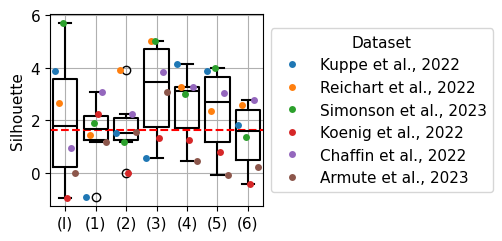

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(metric, results, value='z-score', show_legend=True, baseline=1.645):
    df = results[results['metric'] == metric].copy()

    # Increase font size
    plt.rcParams.update({'font.size': 11})

    plt.figure(figsize=(2.75, 2.5))
    ax = sns.boxplot(x='stage', y=value, data=df, fill=False, linecolor='black', color='black')
    sns.stripplot(x='stage', y=value, data=df, hue='dataset', dodge=True, jitter=True, ax=ax)
    if baseline:
        plt.axhline(y=baseline, color='red', linestyle='dashed')
    # plt.xticks(rotation=90)
    if show_legend:
        plt.legend(title='Dataset', bbox_to_anchor=(1.00, 0.5), loc='center left')
    else:
        plt.legend([],[], frameon=False)
    plt.grid(True)
    
    # label y axis
    plt.ylabel(metric)
    plt.xlabel('')
    
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/{metric}_plot.pdf', format='pdf')


    plt.show()

# Call the function with 'ARI' as the metric
plot_metric('Silhouette', results=results)

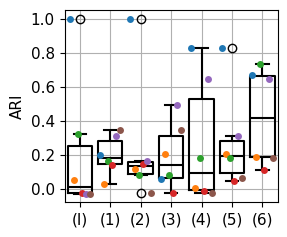

In [29]:
plot_metric('ARI', results=results, show_legend=False, value='gt', baseline=False)

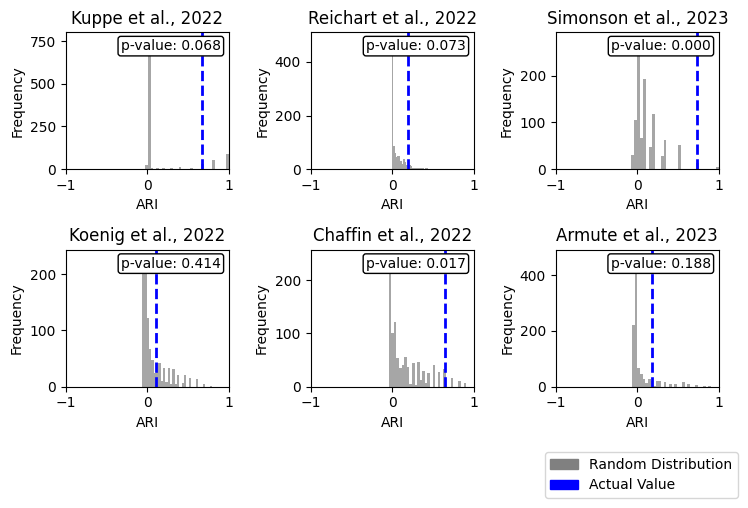

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Increase font size
plt.rcParams.update({'font.size': 10})

def plot_distribution(dataset_name, metric_name, stage, results, ax, xmin=None, xmax=None):
    msk = (results['dataset'] == dataset_name) & (results['metric'] == metric_name) & (results['stage'] == stage)
    random = results[msk]['random']
    gt = results[msk]['gt'].values[0]
    pval = results[msk]['p-value'].values[0]
    
    # Creating the histogram
    ax.hist(random, bins=30, alpha=0.7, color='grey')
    # Adding a vertical line for the ground truth performance
    ax.axvline(gt, color='blue', linestyle='dashed', linewidth=2)

    # Adding labels and title
    ax.set_ylabel('Frequency')
    ax.set_xlabel(metric_name)
    ax.set_title(dataset_name)

    # Setting x-axis limits
    if xmin is not None and xmax is not None:
        ax.set_xlim([xmin, xmax])

    # Adding p-value and z-score as text labels
    ax.text(0.95, 0.95, f'p-value: {pval:.3f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=ax.transAxes, fontsize=10, color='black',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

# Get the unique datasets
sets = results['dataset'].unique()

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.5, 4.5))

# Flatten the axes array
axs = axs.flatten()

# Create a plot for each dataset
for i, dataset in enumerate(sets):
    plot_distribution(dataset_name=dataset, metric_name='ARI', stage='(6)',
                      xmin=-1, xmax=1,
                      results=results, ax=axs[i])

# Remove unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Create custom legend handles
random_patch = mpatches.Patch(color='gray', label='Random Distribution')
actual_line = mpatches.Patch(color='blue', label='Actual Value')
# Add the legend to the figure
fig.legend(handles=[random_patch, actual_line], loc='upper right', bbox_to_anchor=(1, -0.0001))

plt.tight_layout()
plt.savefig('figures/ari_distributions.pdf', format='pdf')
plt.show()

In [26]:
results.to_csv(os.path.join("..", "..", "figures", "source", "ExtData_Fig7.csv"))

In [27]:
# scatter plot of median z-scores of ARI as x axis and Silhoutte as y axis
results

,stage,metric,gt,p-value,z-score,dataset,random
0,(I),ARI,1.000000,0.006963,2.459180,"Kuppe et al., 2022","[0.02620967741935484, -0.020161290322580645, 0..."
1,(I),Silhouette,0.310591,0.000058,3.855792,"Kuppe et al., 2022","[0.13298783, 0.14094529, 0.2016166, 0.18197508..."
2,(I),ARI,0.050555,0.510952,-0.027455,"Reichart et al., 2022","[0.05019181191330842, 0.03033056118526801, 0.0..."
3,(I),Silhouette,0.093364,0.004060,2.647000,"Reichart et al., 2022","[0.090477444, 0.042997155, 0.05456615, 0.05855..."
4,(I),ARI,0.321608,0.093917,1.317014,"Simonson et al., 2023","[0.05778894472361809, 1.0, 0.05778894472361809..."
...,...,...,...,...,...,...,...
79,(6),Silhouette,0.061386,0.656400,-0.402658,"Koenig et al., 2022","[0.079881415, 0.019909529, 0.06114451, 0.04398..."
80,(6),ARI,0.645855,0.016814,2.124505,"Chaffin et al., 2022","[-0.01825442099258414, 0.4285021497714767, -0...."
81,(6),Silhouette,0.122770,0.002848,2.764787,"Chaffin et al., 2022","[0.07533091, 0.056624264, 0.040343337, 0.04376..."
82,(6),ARI,0.183308,0.187532,0.887027,"Armute et al., 2023","[-0.05277329025309639, -0.048728813559322036, ..."
